### Fully Automated Cardiac Shape Modeling

End-to-End automation of the Cardiac Atlas Project, from SSFP MRI to CIM Mesh. 

Steps:
1. View selection
2. Short axis slice selection
3. End-diastole and end-systole selection
     - Export Slice Info File
4. Landmark localization
5. Segmentation
6. Guide point extraction
     - Export guide point file
7. Python CIM GP fitting

In [10]:
# view selection
import os
import sys

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
import path
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print('Python: {}'.format(sys.version))
print('Pydicom: {}'.format(pydicom.__version__))
print('TensorFlow: {}'.format(tf.__version__))

Python: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Pydicom: 2.3.0
TensorFlow: 2.8.0


In [11]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [12]:
# Only use CPU for right now - Set CPU as only available physical device
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

### Step 1: View Selection

The automated view selection is designed to automatically identify and select MRI views that are relavent to cardiac modeling. The analysis is designed to be run over a directory containing one or multiple patient subdirectories. The code runs the analysis iteratively over each subdirectory.

The suggested directory structures for each approach are shown below:

Run the analysis over each patient in a directory individually (i.e., analysis for patient 1, then analysis for patient 2.)

```bash
├── DATA
    ├── Patient1
    │   ├── 1.dcm
    │   ├── 2.dcm 
    │   ├── 3.dcm          
    │   └── ...   
    └── Patient2
        ├── 1.dcm
        ├── 2.dcm 
        ├── 3.dcm          
        └── ...          
```

In [13]:
# import the view selection scripts
from viewselection import ViewSelection

# PARAMETERS for the analysis
patient = 'CHD1055301'
src = "../data/raw/Longitudinal Raw MRI/" + patient          # PATH to the directory containing the desired DICOM files (str)
dst = "../data/processed/"                       # PATH to the output directory to save dicom files (only valid if save_dicoms = True) (str)

# view selection model
modelname = 'ResNet50'                            # The neural network to load and used (Options: VGG19, ResNet50, or Xception)
use_multiprocessing = False                       # Use multiprocessing to read header info (True or False)

# parameters for postprocessing/saving
csv_path = '../reports/{}_view_predictions.csv'.format(patient)   # PATH to save the generated csv file (only valide if create_csv = True) (str)
create_csv = True                                 # Save a .csv file with the series level view predictions (True or False)
save_files = True                                 # Save dicom files to new directory (dst) (True or False)
save_only_desired = True                          # Save only dicom files corresponding to desired views (True or False)
confidence_value = 0.7                            # Only save series if the confidence is > a certain value (set to 0 to save all desired series, regardless of confidence) (float 0-1.0)

In [7]:
# initialize the viewSelector class with appropriate settings
viewSelector = ViewSelection(
                            src,
                            dst,
                            modelname,
                            csv_path,
                            create_csv,
                            use_multiprocessing,
                            save_files,
                            save_only_desired,
                            confidence_value
                            )

In [8]:
# initiate the tensorflow model
viewSelector.load_tensorflow_model()

# make predictions for src directory
viewSelector.complete_view_prediction()

In [87]:
import ipywidgets as widgets

# the view predictions are saved to the specified csv_path file. We can load in this csv file and 
# see what views were predicted for each series in the raw MRI dump. 
views = pd.read_csv(csv_path)
selected = views[views['Confidence'] > confidence_value] # select only
selected = selected[selected['Predicted View'].isin(['4CH', '3CH', 'SA', 'LVOT', 'RVOT'])]
selected

,Patient ID,Series ID,Series Number,Frames,Series Description,Predicted View,Confidence
1,CHD1055301,2.16.124.113543.6006.99.06674102928867389259,701,120,4ch_sense,4CH,1.00
12,CHD1055301,2.16.124.113543.6006.99.04604028601838123734,1001,60,lvot_sense,3CH,0.87
13,CHD1055301,2.16.124.113543.6006.99.06640870602310540123,801,120,rvot_sense,RVOT,1.00
16,CHD1055301,2.16.124.113543.6006.99.06665219082207082022,901,480,sa_sense,SA,1.00
23,CHD1055301,2.16.124.113543.6006.99.06620680814855587194,601,4,bb_-_rvot_clear,RVOT,1.00


In [10]:
# generate widget to change selections if necessary
options = selected['Series Number']
items = [widgets.Checkbox(
    value=True,
    description='Series {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

print('Select Desired LAX and SA Series:')
grid

Select Desired LAX and SA Series:


GridBox(children=(Checkbox(value=True, description='Series 701', indent=False), Checkbox(value=True, descripti…

In [12]:
# remove undesired series
selected_series = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_series.append(int(items[i].description.split(' ')[-1]))

print('Selected Series: ', selected_series)
for (root, subdirs, files) in os.walk(dst):
    for file in files:
        if '.dcm' in file:
            dcm = pydicom.dcmread(os.path.join(root, file))
            if dcm.SeriesNumber not in selected_series:
                os.remove(os.path.join(root, file))
                #os.remove(root)
                break
            else:
                pass
            
selected = selected[selected['Series Number'].isin(selected_series)]
print('Undesired files removed')

Selected Series:  [701, 1001, 801, 901]
Undesired files removed


In [13]:
selected

,Patient ID,Series ID,Series Number,Frames,Series Description,Predicted View,Confidence
1,CHD1055301,2.16.124.113543.6006.99.06674102928867389259,701,120,4ch_sense,4CH,1.00
12,CHD1055301,2.16.124.113543.6006.99.04604028601838123734,1001,60,lvot_sense,3CH,0.87
13,CHD1055301,2.16.124.113543.6006.99.06640870602310540123,801,120,rvot_sense,RVOT,1.00
16,CHD1055301,2.16.124.113543.6006.99.06665219082207082022,901,480,sa_sense,SA,1.00


### Step 2: Phase Selection - ED and ES

The following code performs end-diastolic and end-systolic phase selection from the short-axis stack of images selected above.

Now that we have identified some potential series, we can go ahead and load the dicom files for these series. The code below iterates over all the dicom files in the input directory, selecting each desired series.

In [14]:
print('Reading file list...')
unsortedList = []
for root, dirs, files in os.walk(dst):
    for file in files: 
        if 'SA' in root: # only load the short axis images
            if ".dcm" in file: # exclude non-dicoms, good for messy folders
                unsortedList.append(os.path.join(root, file))

print('%s files found.' % len(unsortedList))

Reading file list...
480 files found.


In [15]:
# import the phase selection module
from phaseselection import PhaseSelection

In [16]:
# initialize the phase selector with the list of short-axis images (unordered) and series IDs
phaseSelector = PhaseSelection(unsortedList, list(selected['Series ID']))

# initialize the tensorflow model
phaseSelector.load_tensorflow_model()

# make phase predictions
out = phaseSelector.predict_phase()

# add prediction to dataframe loaded from csv previously
for series in out.keys():    
    selected.loc[selected['Series ID'] == series, ['ES Phase Prediction']] = out[series]
    
es_phase = int(np.max(selected['ES Phase Prediction']))
selected

Loading dicom header information...


100%|███████████████████████████████████████████████████████████████████████████████| 480/480 [00:02<00:00, 202.55it/s]



Making ES phase predictions for each slice in the short-axis stack...


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:59<00:00, 19.95s/it]


,Patient ID,Series ID,Series Number,Frames,Series Description,Predicted View,Confidence,ES Phase Prediction
1,CHD1055301,2.16.124.113543.6006.99.06674102928867389259,701,120,4ch_sense,4CH,1.00,NaN
12,CHD1055301,2.16.124.113543.6006.99.04604028601838123734,1001,60,lvot_sense,3CH,0.87,NaN
13,CHD1055301,2.16.124.113543.6006.99.06640870602310540123,801,120,rvot_sense,RVOT,1.00,NaN
16,CHD1055301,2.16.124.113543.6006.99.06665219082207082022,901,480,sa_sense,SA,1.00,13.0


In [17]:
# save this dataframe to a new csv file
selected.to_csv('../reports/{}_phase_predictions.csv'.format(selected.iloc[0]['Patient ID']))

### Step 3: SA Slice Selection

In the next step, we will select the slices of the SA stack that will be useable for cardiac modeling (typically spanning from the apex to the base). 

(16, 30, 224, 224, 1)


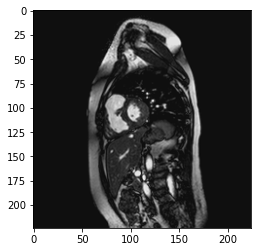

In [18]:
# load the 4D (3D + time) short axis stack - was previously generated by the phaseSelector
sa_stack = phaseSelector.volume
print(sa_stack.shape)

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(sa_stack[8,15,:,:,0], cmap='gray')
plt.show()

In [19]:
# load the slice selection model
MODELPATH = '../models/SliceSelection/slice_selection.hdf5'
model = tf.keras.models.load_model(MODELPATH)

In [20]:
import cv2

slice_selection_preds = []
for slice in range(sa_stack.shape[0]):
    for phase in range(sa_stack.shape[1]):
        image = sa_stack[slice, phase, :, :, 0]
    
        # resize image
        img = np.expand_dims(image, -1)
        img = img/np.max(img)

        # normalize
        img = img*255
        img = img.astype(np.uint8)
        img = cv2.resize(img, (224,224))

        # convert to rgb
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # make prediction
        pred = model.predict(np.expand_dims(img, 0))
        slice_selection_preds.append([phase, slice, np.argmax(pred)])

In [21]:
preds_df = pd.DataFrame(slice_selection_preds, columns=['Filepath', 'Location', 'Prediction'])
slice_locations = np.sort([float(x) for x in preds_df['Location'].unique()])

good_locations = []
report = []
for loc in slice_locations:
    
    loc_df = preds_df[preds_df['Location'] == loc]
    if np.mean(loc_df['Prediction']) > 0.75:
        label = 'Good'
        good_locations.append(str(loc))
    else:
        label = 'Bad'
        
    report.append([loc, np.mean(loc_df['Prediction']), label])
pd.DataFrame(report, columns=['Slice Loc.', 'Pred Value', 'Label'])

,Slice Loc.,Pred Value,Label
0,0.0,0.000000,Bad
1,1.0,0.066667,Bad
2,2.0,0.633333,Bad
3,3.0,0.666667,Bad
4,4.0,0.933333,Good
5,5.0,1.000000,Good
6,6.0,1.000000,Good
7,7.0,1.000000,Good
8,8.0,1.000000,Good
9,9.0,1.000000,Good


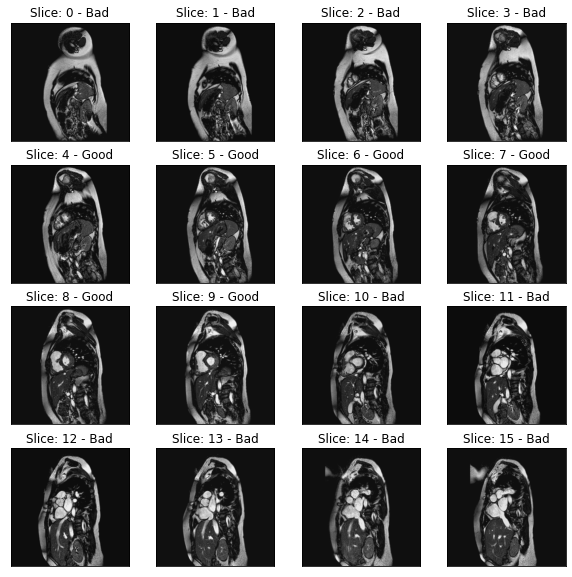

In [22]:
fig, ax = plt.subplots(int(np.ceil(len(slice_locations)/4)), 4, figsize=(10,10))

for i in range(4):
    for j in range(int(np.ceil(len(slice_locations)/4))):
        
        idx = i*4 + j
        if idx > len(slice_locations)-1:
            break
            
        loc = slice_locations[idx]    
        try:
            loc_df = preds_df[preds_df['Location'] == loc]

            ax[i,j].imshow(sa_stack[idx, 15, :, :, 0], cmap='gray')
            if str(loc) in good_locations:
                ax[i,j].set_title('Slice: {} - Good'.format(idx))
            else:
                ax[i,j].set_title('Slice: {} - Bad'.format(idx))
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
        except:
            pass

plt.show()

In [23]:
items = []
for i, loc in enumerate(slice_locations):
    if str(loc) in good_locations:
        items.append(widgets.Checkbox(
            value=True,
            description='Slice {} - {}'.format(i, loc),
            disabled=False,
            indent=False))
    else:
        items.append(widgets.Checkbox(
            value=False,
            description='Slice {} - {}'.format(i, loc),
            disabled=False,
            indent=False))

In [24]:
# make widget with sa slice options
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=False, description='Slice 0 - 0.0', indent=False), Checkbox(value=False, desc…

In [25]:
# remove undesired series
good_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        good_locations.append(str(items[i].description.split(' ')[-1]))
        
good_locations

['4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

### Export 1 - Generate Slice Info File

In [127]:
# generate slice info file for use with python CIM
patient = 'CHD1055301'
sliceID = 0
out = []

# check for SA first
for subdir in os.listdir(os.path.join(dst, patient)):
    #if subdir == 'SA':
    if '.' not in subdir:
        stored_locs = []
        for file in os.listdir(os.path.join(dst, patient, subdir)):
            dcm = pydicom.dcmread(os.path.join(dst, patient, subdir, file))
            #if dcm.SliceLocation in good_locations:
            SOPInstanceUID = str(dcm.SOPInstanceUID)
            imagePositionPatient = dcm.ImagePositionPatient
            imageOrientationPatient = dcm.ImageOrientationPatient
            pixelSpacing = dcm.PixelSpacing

            if dcm.SliceLocation not in stored_locs:
                row = [sliceID, file, subdir, dcm.SliceLocation, imagePositionPatient, imageOrientationPatient, pixelSpacing]
                out.append(row)
                stored_locs.append(dcm.SliceLocation)
                sliceID += 1

# generate dataframe
df = pd.DataFrame(out, columns = ['Slice ID', 'File', 'View', 'Slice Location', 'ImagePositionPatient', 'ImageOrientationPatient', 'Pixel Spacing'])

# generate mapping dictionary (short-axis slice to slice id) for future use
sa_df_sorted = df[df['View']=='SA'].sort_values('Slice Location', axis=0)
sa_mapping_dict = {}
for i, row in enumerate(sa_df_sorted.iterrows()):
    index, row = row[0], row[1]
    slice_id = row['Slice ID']
    sa_mapping_dict[slice_id] = i

# display slice info
df

,Slice ID,File,View,Slice Location,ImagePositionPatient,ImageOrientationPatient,Pixel Spacing
0,0,MR.2.16.124.113543.6006.99.0460402860183812373...,3CH,8.000001,"[-161.91457531042, -157.27283625304, 104.45353...","[0.89826780557632, -0.0896837934851, -0.430199...","[1.484375, 1.484375]"
1,1,MR.2.16.124.113543.6006.99.0460402860183812373...,3CH,0.000000,"[-165.42910549230, -158.93103365600, 97.460791...","[0.89826780557632, -0.0896837934851, -0.430199...","[1.484375, 1.484375]"
2,2,MR.2.16.124.113543.6006.99.0667410292886738925...,4CH,24.000000,"[-200.26627020537, -182.14791444689, -99.87653...","[0.98218160867691, 0.02390478178858, -0.186407...","[1.484375, 1.484375]"
3,3,MR.2.16.124.113543.6006.99.0667410292886738925...,4CH,0.000000,"[-204.17947866022, -167.70886567980, -118.6435...","[0.98218160867691, 0.02390478178858, -0.186407...","[1.484375, 1.484375]"
4,4,MR.2.16.124.113543.6006.99.0667410292886738925...,4CH,15.999999,"[-201.57067303359, -177.33489755541, -106.1322...","[0.98218160867691, 0.02390478178858, -0.186407...","[1.484375, 1.484375]"
5,5,MR.2.16.124.113543.6006.99.0667410292886738925...,4CH,7.999999,"[-202.87507586181, -172.52188257128, -112.3878...","[0.98218160867691, 0.02390478178858, -0.186407...","[1.484375, 1.484375]"
6,6,MR.2.16.124.113543.6006.99.0664087060231054012...,RVOT,0.000000,"[105.002112731337, -124.14129754155, 184.70926...","[-0.5386930108070, 0.84117394685745, -0.047288...","[1.484375, 1.484375]"
7,7,MR.2.16.124.113543.6006.99.0664087060231054012...,RVOT,21.000000,"[87.3182505220174, -135.46739693731, 184.68710...","[-0.5386930108070, 0.84117394685745, -0.047288...","[1.484375, 1.484375]"
8,8,MR.2.16.124.113543.6006.99.0664087060231054012...,RVOT,6.999999,"[99.1074921935796, -127.91666337102, 184.70188...","[-0.5386930108070, 0.84117394685745, -0.047288...","[1.484375, 1.484375]"
9,9,MR.2.16.124.113543.6006.99.0664087060231054012...,RVOT,14.000000,"[93.2128714174032, -131.69203110784, 184.69449...","[-0.5386930108070, 0.84117394685745, -0.047288...","[1.484375, 1.484375]"


In [27]:
# write to slice info file
with open(os.path.join(dst, patient, 'SliceInfo.txt'), 'w') as f:
    for i, row in df.iterrows():
        sliceID = row['Slice ID']
        file = row['File']
        view = row['View']
        imagePositionPatient = row['ImagePositionPatient']
        imageOrientationPatient = row['ImageOrientationPatient']
        pixelSpacing = row['Pixel Spacing']
        
        f.write('{}\t'.format(file))
        f.write('frameID: {}\t'.format(sliceID))
        f.write('timeFrame\t1\t')
        f.write('ImagePositionPatient\t')
        f.write('{}\t{}\t{}\t'.format(imagePositionPatient[0], imagePositionPatient[1], imagePositionPatient[2]))
        f.write('ImageOrientationPatient\t')
        f.write('{}\t{}\t{}\t{}\t{}\t{}\t'.format(imageOrientationPatient[0], imageOrientationPatient[1], imageOrientationPatient[2],
                                            imageOrientationPatient[3], imageOrientationPatient[4], imageOrientationPatient[5]))
        f.write('Pixel Spacing\t')
        f.write('{}\t{}\n'.format(pixelSpacing[0], pixelSpacing[1]))

### Step 4: Landmark Localization

### 4.1 Short-Axis RV Inserts

In [92]:
from landmarklocalization import LandmarkLocalization

In [63]:
# path to the processed dicoms (dicoms that slice info references)
directory = dst + patient
directory

'../data/processed/CHD1055301'

In [144]:
# convert selected slice locations into slice IDs
selected_sa_ids = [x for x in sa_mapping_dict.keys() if str(float(sa_mapping_dict[x])) in good_locations]
selected_sa_ids

[12, 13, 14, 15, 16, 17]

In [148]:
# Initiate a landmark localization module in the short-axis view
ShortAxisLoc = LandmarkLocalization( directory, df, 'SA' )

# load model and generate inputs
ShortAxisLoc.load_tensorflow_model()
ShortAxisLoc.generate_mapping_dictionary()
ShortAxisLoc.generate_complete_volume()

# Make landmark predictions for ED phase
ShortAxisLoc.predict_landmarks(phase=0)
ed_output = ShortAxisLoc.output

# Make landmark predictions for ES phase
ShortAxisLoc.predict_landmarks(phase=es_phase)
es_output = ShortAxisLoc.output

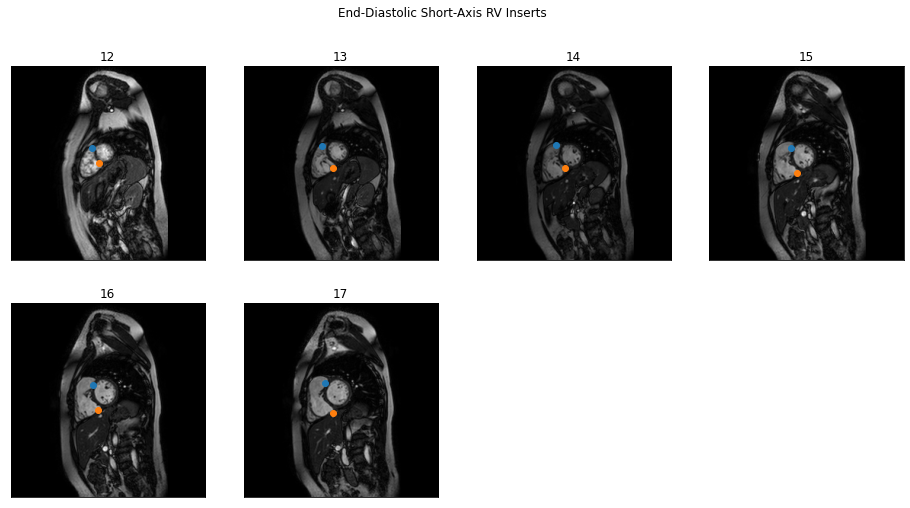

In [150]:
# Store outputs and display inputs/predictions for review
volume = ShortAxisLoc.volume

cols = 4
rows = np.ceil(len(selected_ids)/cols)

plt.figure(figsize = (16,4*rows))
count = 1
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    if slice_id in selected_ids:
        p1 = slice[3]
        p2 = slice[4]
        image = volume[slice_id, 0, :, :, 0]

        ax = plt.subplot(rows, cols, count)
        ax.imshow(image, cmap='gray')
        ax.scatter(x=p1[1], y=p1[0])
        ax.scatter(x=p2[1], y=p2[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(slice_id)
        count += 1
plt.suptitle('End-Diastolic Short-Axis RV Inserts')   
plt.show()

In [157]:
sa_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'RV1', 'RV2'])
sa_df = sa_df.append(pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'RV1', 'RV2']))
sa_df = sa_df[sa_df['Slice ID'].isin(selected_sa_ids)]
sa_df

,Slice ID,View,Time Frame,RV1,RV2
2,12,SA,0,"([107], [107])","([127], [116])"
3,13,SA,0,"([105], [103])","([134], [117])"
4,14,SA,0,"([104], [105])","([134], [116])"
5,15,SA,0,"([107], [107])","([141], [115])"
6,16,SA,0,"([107], [108])","([141], [115])"
7,17,SA,0,"([105], [107])","([144], [117])"
2,12,SA,13,"([111], [103])","([125], [111])"
3,13,SA,13,"([107], [103])","([125], [112])"
4,14,SA,13,"([111], [107])","([128], [110])"
5,15,SA,13,"([111], [107])","([135], [110])"


### 4.2 Four Chamber Landmark Localization

In [158]:
# Initiate a landmark localization module in the four chamber view
FourChamberLoc = LandmarkLocalization( directory, df, '4CH' )

# Load tensorflow model and inputs
FourChamberLoc.load_tensorflow_model()
FourChamberLoc.generate_mapping_dictionary()
FourChamberLoc.generate_complete_volume()

# Make predictions for ED phase
FourChamberLoc.predict_landmarks(phase=0)
ed_output = FourChamberLoc.output

# Make predictions for ES phase
FourChamberLoc.predict_landmarks(phase=es_phase)
es_output = FourChamberLoc.output

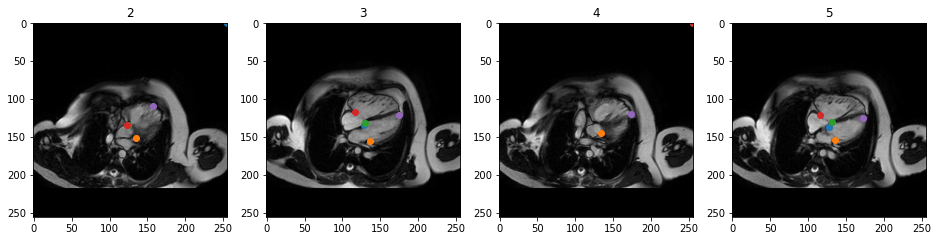

In [159]:
volume = FourChamberLoc.volume

cols = 4
rows = np.ceil(len(ed_output)/cols)

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]
    p5 = slice[7]

    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    ax.scatter(x=p1[1], y=p1[0])
    ax.scatter(x=p2[1], y=p2[0])
    ax.scatter(x=p3[1], y=p3[0])
    ax.scatter(x=p4[1], y=p4[0])
    ax.scatter(x=p5[1], y=p5[0])
    
plt.suptitle('End-Diastolic Four Chamber')  
plt.show()

In [160]:
options = list(df[df['View'] == '4CH']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=True, description='Slice ID 2', indent=False), Checkbox(value=True, descripti…

In [161]:
selected_4ch_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_4ch_locations.append(int(items[i].description.split(' ')[-1]))

In [162]:
four_chamber_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'TV1', 'TV2', 'LVA'])
four_chamber_df = four_chamber_df.append(
    pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'TV1', 'TV2', 'LVA'])
)
four_chamber_df = four_chamber_df[four_chamber_df['Slice ID'].isin(selected_4ch_locations)]
four_chamber_df

,Slice ID,View,Time Frame,MV1,MV2,TV1,TV2,LVA
1,3,4CH,0,"([135], [128])","([155], [136])","([132], [130])","([117], [117])","([121], [175])"
3,5,4CH,0,"([137], [128])","([154], [135])","([131], [131])","([121], [115])","([125], [172])"
1,3,4CH,13,"([137], [129])","([150], [142])","([130], [134])","([116], [122])","([116], [170])"
3,5,4CH,13,"([137], [128])","([154], [141])","([132], [131])","([118], [121])","([117], [171])"


### 4.3 Three Chamber Landmark Localization

In [163]:
# Initiate a landmark localization module in the three chamber view
ThreeChamberLoc = LandmarkLocalization( directory, df, '3CH' )

# Load tensorflow model and inputs
ThreeChamberLoc.load_tensorflow_model()
ThreeChamberLoc.generate_mapping_dictionary()
ThreeChamberLoc.generate_complete_volume()

# Make predictions for ED phase
ThreeChamberLoc.predict_landmarks(phase=0)
ed_output = ThreeChamberLoc.output

# Make predictions for ES phase
ThreeChamberLoc.predict_landmarks(phase=es_phase)
es_output = ThreeChamberLoc.output

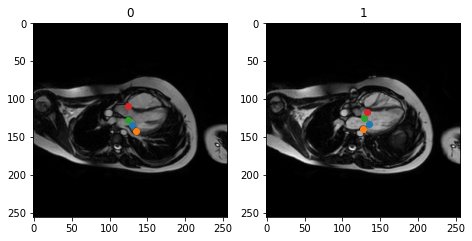

In [164]:
volume = ThreeChamberLoc.volume

cols = 4
rows = np.ceil(len(ed_output)/cols)

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]

    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    ax.scatter(x=p1[1], y=p1[0])
    ax.scatter(x=p2[1], y=p2[0])
    ax.scatter(x=p3[1], y=p3[0])
    ax.scatter(x=p4[1], y=p4[0])
    
plt.show()

In [165]:
options = list(df[df['View'] == '3CH']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=True, description='Slice ID 0', indent=False), Checkbox(value=True, descripti…

In [166]:
selected_3ch_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_3ch_locations.append(int(items[i].description.split(' ')[-1]))

In [167]:
three_chamber_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'AV1', 'AV2'])
three_chamber_df = three_chamber_df.append(
    pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'AV1', 'AV2'])
)

three_chamber_df = three_chamber_df[three_chamber_df['Slice ID'].isin(selected_3ch_locations)]
three_chamber_df

,Slice ID,View,Time Frame,MV1,MV2,AV1,AV2
0,0,3CH,0,"([134], [130])","([142], [135])","([128], [124])","([109], [125])"
0,0,3CH,13,"([128], [142])","([139], [141])","([120], [130])","([109], [131])"


### 4.4 RVOT Landmark Localization

In [168]:
# Initiate a landmark localization module in the RVOT view
RVOTLoc = LandmarkLocalization( directory, df, 'RVOT' )

# Load tensorflow model and inputs
RVOTLoc.load_tensorflow_model()
RVOTLoc.generate_mapping_dictionary()
RVOTLoc.generate_complete_volume()

# Make predictions for ED phase
RVOTLoc.predict_landmarks(phase=0)
ed_output = RVOTLoc.output

# Make predictions for ES phase
RVOTLoc.predict_landmarks(phase=es_phase)
es_output = RVOTLoc.output

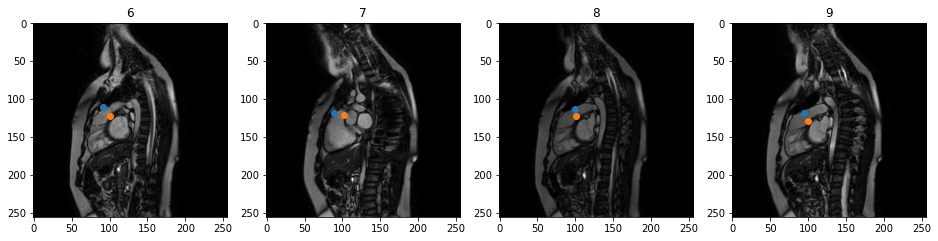

In [169]:
volume = RVOTLoc.volume

cols = 4
rows = np.ceil(len(ed_output)/cols)

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]

    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    ax.scatter(x=p1[1], y=p1[0])
    ax.scatter(x=p2[1], y=p2[0])
    
plt.show()

In [170]:
options = list(df[df['View'] == 'RVOT']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=True, description='Slice ID 6', indent=False), Checkbox(value=True, descripti…

In [171]:
selected_rvot_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_rvot_locations.append(int(items[i].description.split(' ')[-1]))

In [173]:
rvot_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'PV1', 'PV2'])
rvot_df = rvot_df.append(pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'PV1', 'PV2']))
rvot_df = rvot_df[rvot_df['Slice ID'].isin(selected_rvot_locations)]
rvot_df

,Slice ID,View,Time Frame,PV1,PV2
0,6,RVOT,0,"([111], [92])","([122], [100])"
3,9,RVOT,0,"([119], [94])","([129], [100])"
0,6,RVOT,13,"([111], [95])","([125], [99])"
3,9,RVOT,13,"([121], [83])","([130], [100])"


### 5. Inverse Transform - Image to Model Coordinates

In [174]:
def inverse_coordinate_transformation(coordinate, imagePositionPatient, imageOrientationPatient, ps):

    # image position and orientation
    S = imagePositionPatient
    X = imageOrientationPatient[:3]
    Y = imageOrientationPatient[3:]
    
    # construct affine transform
    M = np.asarray([[X[0]*ps[0], Y[0]*ps[1], 0, S[0]],
                [X[1]*ps[0], Y[1]*ps[1], 0, S[1]],
                [X[2]*ps[0], Y[2]*ps[1], 0, S[2]],
                [0, 0, 0, 1]])
    
    # expand dimensions of coordinate
    pos = [float(x) for x in coordinate[0:3]]
    coord = [pos[1], pos[0], 0, 1.0]
    
    # perform transformation and return as list
    return [np.round(x,5) for x in M @ coord]

In [175]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

In [177]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
for i, row in sa_df.iterrows():
    if row['Time Frame'] == 0:
        rv1 = row['RV1']
        rv2 = row['RV2']
        sliceID = row['Slice ID']

        # extract transform info
        row = df[df['Slice ID'] == sliceID].copy()
        S = row['ImagePositionPatient'].values[0]
        imgOrient = row['ImageOrientationPatient'].values[0]
        ps = row['Pixel Spacing'].values[0]

        # transform point
        p1 = inverse_coordinate_transformation(rv1, S, imgOrient, ps)
        p2 = inverse_coordinate_transformation(rv2, S, imgOrient, ps)

        if i == 0:
            ax.scatter3D(p1[0], p1[1], p1[2], c='r', label='RV Insert')
        else:
            ax.scatter3D(p1[0], p1[1], p1[2], c='r')
        ax.scatter3D(p2[0], p2[1], p2[2], c='r')
    
for i, row in four_chamber_df.iterrows():
    
    if row['Time Frame'] == 0:
        rv1 = row['MV1']
        rv2 = row['MV2']
        tv1 = row['TV1']
        tv2 = row['TV2']
        lva = row['LVA']
        sliceID = row['Slice ID']
        print(sliceID)

        # extract transform info
        row = df[df['Slice ID'] == sliceID].copy()
        S = row['ImagePositionPatient'].values[0]
        imgOrient = row['ImageOrientationPatient'].values[0]
        ps = row['Pixel Spacing'].values[0]

        # transform point
        p1 = inverse_coordinate_transformation(rv1, S, imgOrient, ps)
        print(p1)
        p2 = inverse_coordinate_transformation(rv2, S, imgOrient, ps)
        p3 = inverse_coordinate_transformation(tv1, S, imgOrient, ps)
        p4 = inverse_coordinate_transformation(tv2, S, imgOrient, ps)
        p5 = inverse_coordinate_transformation(lva, S, imgOrient, ps)

        ax.scatter3D(p1[0], p1[1], p1[2], c='b', label='MV Insert')
        ax.scatter3D(p2[0], p2[1], p2[2], c='b')
        ax.scatter3D(p3[0], p3[1], p3[2], c='g', label='TV Insert')
        ax.scatter3D(p4[0], p4[1], p4[2], c='g')
        ax.scatter3D(p5[0], p5[1], p5[2], c='yellow', label='LVA')
        
for i, row in three_chamber_df.iterrows():
    
    if row['Time Frame'] == 0:
        rv1 = row['MV1']
        rv2 = row['MV2']
        av1 = row['AV1']
        av2 = row['AV2']
        sliceID = row['Slice ID']

        # extract transform info
        row = df[df['Slice ID'] == sliceID].copy()
        S = row['ImagePositionPatient'].values[0]
        imgOrient = row['ImageOrientationPatient'].values[0]
        ps = row['Pixel Spacing'].values[0]

        # transform point
        p1 = inverse_coordinate_transformation(rv1, S, imgOrient, ps)
        print(p1)
        p2 = inverse_coordinate_transformation(rv2, S, imgOrient, ps)
        p3 = inverse_coordinate_transformation(av1, S, imgOrient, ps)
        p4 = inverse_coordinate_transformation(av2, S, imgOrient, ps)

        ax.scatter3D(p1[0], p1[1], p1[2], c='lightblue', label='MV Insert From 3CH')
        ax.scatter3D(p2[0], p2[1], p2[2], c='lightblue')
        ax.scatter3D(p3[0], p3[1], p3[2], c='pink', label='AV Insert')
        ax.scatter3D(p4[0], p4[1], p4[2], c='pink')
    
for i, row in rvot_df.iterrows():
    
    if row['Time Frame'] == 0:
        rv1 = row['PV1']
        rv2 = row['PV2']
        sliceID = row['Slice ID']

        # extract transform info
        row = df[df['Slice ID'] == sliceID].copy()
        S = row['ImagePositionPatient'].values[0]
        imgOrient = row['ImageOrientationPatient'].values[0]
        ps = row['Pixel Spacing'].values[0]

        # transform point
        p1 = inverse_coordinate_transformation(rv1, S, imgOrient, ps)
        p2 = inverse_coordinate_transformation(rv2, S, imgOrient, ps)

        ax.scatter3D(p1[0], p1[1], p1[2], c='lightgreen', label='PV Insert')
        ax.scatter3D(p2[0], p2[1], p2[2], c='lightgreen')
        
plt.xlim([-50,50])
plt.ylim([-50,50])
plt.legend()
plt.show()

3
[1.16263, -3.1712, -34.86777, 1.0]
5
[2.74448, -5.61391, -26.84627, 1.0]
[9.27933, 19.18816, -23.43235, 1.0]


#### 5.1 Export 2 - Generate GP File

In [178]:
with open(os.path.join(dst, patient, 'GP_ED.txt'), 'w') as f:
    
    f.write('x\ty\tz\tcontour type\tframeID\tweight\ttime frame\n')
    
    for i, row in sa_df.iterrows():
        if row['Time Frame'] == 0:
            rv1 = row['RV1']
            rv2 = row['RV2']
            sliceID = row['Slice ID']

            # extract transform info
            row = df[df['Slice ID'] == sliceID].copy()
            S = row['ImagePositionPatient'].values[0]
            imgOrient = row['ImageOrientationPatient'].values[0]
            ps = row['Pixel Spacing'].values[0]

            # transform point
            p1 = inverse_coordinate_transformation(rv1, S, imgOrient, ps)
            p2 = inverse_coordinate_transformation(rv2, S, imgOrient, ps)

            f.write('{}\t{}\t{}\tRV_INSERT\t{}\t{}\t{}\n'.format(p1[0], p1[1], p1[2], sliceID, 1.0, 1.0))
            f.write('{}\t{}\t{}\tRV_INSERT\t{}\t{}\t{}\n'.format(p2[0], p2[1], p2[2], sliceID, 1.0, 1.0))


    for i, row in four_chamber_df.iterrows():
        if row['Time Frame'] == 0:
            mv1 = row['MV1']
            mv2 = row['MV2']
            tv1 = row['TV1']
            tv2 = row['TV2']
            lva = row['LVA']
            sliceID = row['Slice ID']

            # extract transform info
            row = df[df['Slice ID'] == sliceID].copy()
            S = row['ImagePositionPatient'].values[0]
            imgOrient = row['ImageOrientationPatient'].values[0]
            ps = row['Pixel Spacing'].values[0]

            # transform point
            p1 = inverse_coordinate_transformation(mv1, S, imgOrient, ps)
            p2 = inverse_coordinate_transformation(mv2, S, imgOrient, ps)
            p3 = inverse_coordinate_transformation(tv1, S, imgOrient, ps)
            p4 = inverse_coordinate_transformation(tv2, S, imgOrient, ps)
            p5 = inverse_coordinate_transformation(lva, S, imgOrient, ps)

            f.write('{}\t{}\t{}\tMITRAL_VALVE\t{}\t{}\t{}\n'.format(p1[0], p1[1], p1[2], sliceID, 1.0, 1.0))
            f.write('{}\t{}\t{}\tMITRAL_VALVE\t{}\t{}\t{}\n'.format(p2[0], p2[1], p2[2], sliceID, 1.0, 1.0))
            f.write('{}\t{}\t{}\tTRICUSPID_VALVE\t{}\t{}\t{}\n'.format(p3[0], p3[1], p3[2], sliceID, 1.0, 1.0))
            f.write('{}\t{}\t{}\tTRICUSPID_VALVE\t{}\t{}\t{}\n'.format(p4[0], p4[1], p4[2], sliceID, 1.0, 1.0))         
            f.write('{}\t{}\t{}\tAPEX POINT\t{}\t{}\t{}\n'.format(p5[0], p5[1], p5[2], sliceID, 1.0, 1.0))

    for i, row in three_chamber_df.iterrows():
        if row['Time Frame'] == 0:
            mv1 = row['MV1']
            mv2 = row['MV2']
            av1 = row['AV1']
            av2 = row['AV2']
            sliceID = row['Slice ID']

            # extract transform info
            row = df[df['Slice ID'] == sliceID].copy()
            S = row['ImagePositionPatient'].values[0]
            imgOrient = row['ImageOrientationPatient'].values[0]
            ps = row['Pixel Spacing'].values[0]

            # transform point
            p1 = inverse_coordinate_transformation(mv1, S, imgOrient, ps)
            p2 = inverse_coordinate_transformation(mv2, S, imgOrient, ps)
            p3 = inverse_coordinate_transformation(av1, S, imgOrient, ps)
            p4 = inverse_coordinate_transformation(av2, S, imgOrient, ps)

            f.write('{}\t{}\t{}\tMITRAL_VALVE\t{}\t{}\t{}\n'.format(p1[0], p1[1], p1[2], sliceID, 1.0, 1.0))
            f.write('{}\t{}\t{}\tMITRAL_VALVE\t{}\t{}\t{}\n'.format(p2[0], p2[1], p2[2], sliceID, 1.0, 1.0))
            f.write('{}\t{}\t{}\tAORTA_VALVE\t{}\t{}\t{}\n'.format(p3[0], p3[1], p3[2], sliceID, 1.0, 1.0))
            f.write('{}\t{}\t{}\tAORTA_VALVE\t{}\t{}\t{}\n'.format(p4[0], p4[1], p4[2], sliceID, 1.0, 1.0))

    for i, row in rvot_df.iterrows():
        if row['Time Frame'] == 0:
            pv1 = row['PV1']
            pv2 = row['PV2']
            sliceID = row['Slice ID']

            # extract transform info
            row = df[df['Slice ID'] == sliceID].copy()
            S = row['ImagePositionPatient'].values[0]
            imgOrient = row['ImageOrientationPatient'].values[0]
            ps = row['Pixel Spacing'].values[0]

            # transform point
            p1 = inverse_coordinate_transformation(pv1, S, imgOrient, ps)
            p2 = inverse_coordinate_transformation(pv2, S, imgOrient, ps)

            f.write('{}\t{}\t{}\tPULMONARY_VALVE\t{}\t{}\t{}\n'.format(p1[0], p1[1], p1[2], sliceID, 1.0, 1.0))
            f.write('{}\t{}\t{}\tPULMONARY_VALVE\t{}\t{}\t{}\n'.format(p2[0], p2[1], p2[2], sliceID, 1.0, 1.0))

In [179]:
with open(os.path.join(dst, patient, 'GP_ES.txt'), 'w') as f:
    
    f.write('x\ty\tz\tcontour type\tframeID\tweight\ttime frame\n')
    
    for i, row in sa_df.iterrows():
        if row['Time Frame'] == es_phase:
            rv1 = row['RV1']
            rv2 = row['RV2']
            sliceID = row['Slice ID']

            # extract transform info
            row = df[df['Slice ID'] == sliceID].copy()
            S = row['ImagePositionPatient'].values[0]
            imgOrient = row['ImageOrientationPatient'].values[0]
            ps = row['Pixel Spacing'].values[0]

            # transform point
            p1 = inverse_coordinate_transformation(rv1, S, imgOrient, ps)
            p2 = inverse_coordinate_transformation(rv2, S, imgOrient, ps)

            f.write('{}\t{}\t{}\tRV_INSERT\t{}\t{}\t{}\n'.format(p1[0], p1[1], p1[2], sliceID, 1.0, float(es_phase)))
            f.write('{}\t{}\t{}\tRV_INSERT\t{}\t{}\t{}\n'.format(p2[0], p2[1], p2[2], sliceID, 1.0, float(es_phase)))


    for i, row in four_chamber_df.iterrows():    
        if row['Time Frame'] == es_phase:
            mv1 = row['MV1']
            mv2 = row['MV2']
            tv1 = row['TV1']
            tv2 = row['TV2']
            lva = row['LVA']
            sliceID = row['Slice ID']

            # extract transform info
            row = df[df['Slice ID'] == sliceID].copy()
            S = row['ImagePositionPatient'].values[0]
            imgOrient = row['ImageOrientationPatient'].values[0]
            ps = row['Pixel Spacing'].values[0]

            # transform point
            p1 = inverse_coordinate_transformation(mv1, S, imgOrient, ps)
            p2 = inverse_coordinate_transformation(mv2, S, imgOrient, ps)
            p3 = inverse_coordinate_transformation(tv1, S, imgOrient, ps)
            p4 = inverse_coordinate_transformation(tv2, S, imgOrient, ps)
            p5 = inverse_coordinate_transformation(lva, S, imgOrient, ps)

            f.write('{}\t{}\t{}\tMITRAL_VALVE\t{}\t{}\t{}\n'.format(p1[0], p1[1], p1[2], sliceID, 1.0, float(es_phase)))
            f.write('{}\t{}\t{}\tMITRAL_VALVE\t{}\t{}\t{}\n'.format(p2[0], p2[1], p2[2], sliceID, 1.0, float(es_phase)))
            f.write('{}\t{}\t{}\tTRICUSPID_VALVE\t{}\t{}\t{}\n'.format(p3[0], p3[1], p3[2], sliceID, 1.0, float(es_phase)))
            f.write('{}\t{}\t{}\tTRICUSPID_VALVE\t{}\t{}\t{}\n'.format(p4[0], p4[1], p4[2], sliceID, 1.0, float(es_phase)))         
            f.write('{}\t{}\t{}\tAPEX POINT\t{}\t{}\t{}\n'.format(p5[0], p5[1], p5[2], sliceID, 1.0, float(es_phase)))

    for i, row in three_chamber_df.iterrows():
        if row['Time Frame'] == es_phase:
            mv1 = row['MV1']
            mv2 = row['MV2']
            av1 = row['AV1']
            av2 = row['AV2']
            sliceID = row['Slice ID']

            # extract transform info
            row = df[df['Slice ID'] == sliceID].copy()
            S = row['ImagePositionPatient'].values[0]
            imgOrient = row['ImageOrientationPatient'].values[0]
            ps = row['Pixel Spacing'].values[0]

            # transform point
            p1 = inverse_coordinate_transformation(mv1, S, imgOrient, ps)
            p2 = inverse_coordinate_transformation(mv2, S, imgOrient, ps)
            p3 = inverse_coordinate_transformation(av1, S, imgOrient, ps)
            p4 = inverse_coordinate_transformation(av2, S, imgOrient, ps)

            f.write('{}\t{}\t{}\tMITRAL_VALVE\t{}\t{}\t{}\n'.format(p1[0], p1[1], p1[2], sliceID, 1.0, float(es_phase)))
            f.write('{}\t{}\t{}\tMITRAL_VALVE\t{}\t{}\t{}\n'.format(p2[0], p2[1], p2[2], sliceID, 1.0, float(es_phase)))
            f.write('{}\t{}\t{}\tAORTA_VALVE\t{}\t{}\t{}\n'.format(p3[0], p3[1], p3[2], sliceID, 1.0, float(es_phase)))
            f.write('{}\t{}\t{}\tAORTA_VALVE\t{}\t{}\t{}\n'.format(p4[0], p4[1], p4[2], sliceID, 1.0, float(es_phase)))

    for i, row in rvot_df.iterrows():
        if row['Time Frame'] == es_phase:
            pv1 = row['PV1']
            pv2 = row['PV2']
            sliceID = row['Slice ID']

            # extract transform info
            row = df[df['Slice ID'] == sliceID].copy()
            S = row['ImagePositionPatient'].values[0]
            imgOrient = row['ImageOrientationPatient'].values[0]
            ps = row['Pixel Spacing'].values[0]

            # transform point
            p1 = inverse_coordinate_transformation(pv1, S, imgOrient, ps)
            p2 = inverse_coordinate_transformation(pv2, S, imgOrient, ps)

            f.write('{}\t{}\t{}\tPULMONARY_VALVE\t{}\t{}\t{}\n'.format(p1[0], p1[1], p1[2], sliceID, 1.0, float(es_phase)))
            f.write('{}\t{}\t{}\tPULMONARY_VALVE\t{}\t{}\t{}\n'.format(p2[0], p2[1], p2[2], sliceID, 1.0, float(es_phase)))